**Importing Needed Libraries**

In [ ]:
pip list

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import time
from random import seed
from datetime import datetime

In [ ]:
torch.cuda.is_available()

True

In [ ]:
# Set all random seeds constant for reproducible results
chosen_seed = 40
seed(chosen_seed)
np.random.seed(chosen_seed)
torch.manual_seed(chosen_seed)

torch.cuda.manual_seed_all(chosen_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False

In [ ]:
# Path where Syed wants to keep cifar10 data on his google drive to keep things organized
local_path = './datasets'

In [ ]:
# Options
USE_SIMPLE_AUGM = True
USE_BATCH_NORM = False
USE_DROPOUT = False

In [ ]:
# Defining global variables and hyperparameters
LEARNING_RATE = 0.0003
BATCH_SIZE = 16
NUM_EPOCHS = 30
cifar10_classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Transformations applied to images as they are loaded by the Pytorch dataloader
base_transformations = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768))]
)

augmentation_transformations = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomHorizontalFlip(p=0.3),
     transforms.RandomVerticalFlip(p=0.3),
     torchvision.transforms.RandomRotation(45),
     torchvision.transforms.ColorJitter(),
     transforms.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768))]
)


In [ ]:
# Create dataset and dataloader for cifar10. Pytorch built-in dataloaders handle downloading the cifar10 dataset

# Separate dataloaders for training and test set of cifar10
# - root: path to directory within google drive where cifar10 will be downloaded
# - train: whether or not dataloader is for training
# - download: whether or not to download the cifar10 zip file (to store image data locally)
# - transform: pass previously defined transformations into dataloader, will be applied to images


if USE_SIMPLE_AUGM:
  trainset = torchvision.datasets.CIFAR10(root=local_path, train=True, download=True, transform=augmentation_transformations)
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
else:
  trainset = torchvision.datasets.CIFAR10(root=local_path, train=True, download=True, transform=base_transformations)
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# Always keep test set the same, not doing test set augmentation for purposes of this course
testset = torchvision.datasets.CIFAR10(root=local_path, train=False, download=True, transform=base_transformations)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Function to show images
def show_img(img):
    img = img / 2 + 0.5     # unnormalize
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Images: torch.Size([16, 3, 32, 32])
Labels: torch.Size([16])
tensor([1, 9, 1, 3, 8, 0, 4, 2, 5, 2, 6, 8, 6, 0, 7, 7])


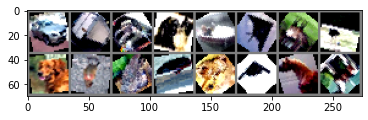

  car truck   car   cat  ship plane  deer  bird   dog  bird  frog  ship  frog plane horse horse


In [ ]:
# Get a few cifar10 images for visualizing
dataiter = iter(trainloader)  # Makes an iterable object in Python for training dataloader
images, labels = dataiter.next()  # Get one batch of images (16 images)

print("Images:", images.shape)
print("Labels:", labels.shape)
print(labels)

# Show images
show_img(torchvision.utils.make_grid(images))
# Print labels
print(' '.join('%5s' % cifar10_classes[labels[j]] for j in range(BATCH_SIZE)))

In [ ]:
print(images.shape)  # batch of 8 images, each image has 3 channels, 32x32 image
print(images[0].shape)

torch.Size([16, 3, 32, 32])
torch.Size([3, 32, 32])


**Defining Convolutional Neural Network**

In [ ]:
# This Convolution Neural Network introduces the ideas of Batch Normalization and Dropout into our simple CNN
# Batch Normalization: https://arxiv.org/pdf/1502.03167.pdf
# Dropout (reduces overfitting): https://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf

class Four_Layer_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Block 1
        self.conv1_1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)  # [3,32,32]  -> [32,32,32]
        self.batch_norm1_1 = nn.BatchNorm2d(32)
        self.conv1_2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)  # [32,32,32]  -> [32,32,32]
        self.batch_norm1_2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)  # [32,32,32] -> [32,16,16]
        self.drop1 = nn.Dropout(p=0.3)
        
        # Block 2
        self.conv2_1 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # [32,16,16]  -> [64,16,16]
        self.batch_norm2_1 = nn.BatchNorm2d(64)
        self.conv2_2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)  # [64,16,16]  -> [64,16,16]
        self.batch_norm2_2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)  # [64,16,16]  -> [64,8,8]
        self.drop2 = nn.Dropout(p=0.3)

        # Flatten (16 comes from batch size, previously just writing single image size): [16,64,8,8] -> [16, 64*8*8]

        # Fully connected classifier
        self.fc1 = nn.Linear(64*8*8, 128)
        self.batch_norm_out = nn.BatchNorm1d(128)
        self.drop_out = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Pass through Block 1
        x = F.relu(self.conv1_1(x))
        if USE_BATCH_NORM:
            x = self.batch_norm1_1(x)
        x = F.relu(self.conv1_2(x))
        if USE_BATCH_NORM:
            x = self.batch_norm1_2(x)
        x = self.pool1(x)
        if USE_DROPOUT:
            x = self.drop1(x)
        
        # Pass through Block 1
        x = F.relu(self.conv2_1(x))
        if USE_BATCH_NORM:
            x = self.batch_norm2_1(x)
        x = F.relu(self.conv2_2(x))
        if USE_BATCH_NORM:
            x = self.batch_norm2_2(x)
        x = self.pool2(x)
        if USE_DROPOUT:
            x = self.drop2(x)

        # Flatten, pass through fully-connected layers to classify features
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        if USE_BATCH_NORM:
            x = self.batch_norm_out(x)
        if USE_DROPOUT:
            x = self.drop_out(x)
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
        return x

In [ ]:
net = Four_Layer_CNN()
net = net.cuda()

In [ ]:
# Get trainable parameter count for neural network
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(net)

591914

In [ ]:
criterion = nn.CrossEntropyLoss()  # Loss function
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)  # Optimizer object that tweaks weights in neural network

**Training Loop for Neural Network**

In [ ]:
experiment_name = "4layer_cnn_simple_aug_lr0003"
date_time_str = datetime.now().strftime('%Y%m%d_%H%M%S')
experiment_log_name = '{}_{}'.format(experiment_name, date_time_str)

In [ ]:
writer_train = SummaryWriter('tf_logs/{}/train'.format(experiment_log_name))
writer_val = SummaryWriter('tf_logs/{}/validation'.format(experiment_log_name))
print('tf_logs/{}/train'.format(experiment_log_name))
print('tf_logs/{}/validation'.format(experiment_log_name))

tf_logs/4layer_cnn_simple_aug_lr0003_20211113_092148/train
tf_logs/4layer_cnn_simple_aug_lr0003_20211113_092148/validation


In [ ]:
# %tensorboard --logdir logs/simple_cnn_30ep_20211103_092431

In [ ]:
def eval(net, epoch): 
  net.eval()
  running_loss = 0.0
  num_correct = 0

  for i, data in enumerate(testloader, 0):
    inputs, labels = data
    inputs, labels = inputs.cuda(), labels.cuda()
    optimizer.zero_grad()

    outputs = net(inputs)
    loss = criterion(outputs, labels)
    
    running_loss += loss.item() * images.size(0)
    num_correct += (torch.argmax(outputs, dim=1) == labels).float().sum() 
  
  epoch_accuracy = 100 * (num_correct / len(testset))
  epoch_loss_average = running_loss / len(testset)
  writer_val.add_scalar('loss', epoch_loss_average, epoch)
  writer_val.add_scalar('acc', epoch_accuracy, epoch)

In [ ]:
loss_values = []
for epoch in range(NUM_EPOCHS):  # loop over the dataset multiple times
    print("Epoch", epoch, end=": ")
    running_loss = 0.0
    num_correct = 0
    net.train()
    start_time = time.time()

    for i, data in enumerate(trainloader, 0):
        # Get inputs; Data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()

        # Zero Parameter Gradients From Previous Computations 
        optimizer.zero_grad() 

        # Pass images through Neural Network, compute loss and gradients, propagate backwards
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step() 

        running_loss += loss.item() * images.size(0)
        num_correct += (torch.argmax(outputs, dim=1) == labels).float().sum()

    epoch_accuracy = 100 * (num_correct / len(trainset))
    epoch_loss_average = running_loss / len(trainset)

    writer_train.add_scalar('loss', epoch_loss_average, epoch)
    writer_train.add_scalar('acc', epoch_accuracy, epoch)
    
    print("Elapsed time ", time.time() - start_time, ", Accuracy ", epoch_accuracy, ", Loss ", epoch_loss_average)


    # Evaluate CNN on validation set once per epoch
    eval(net, epoch) 

print('Finished Training')

Epoch 0: Elapsed time  43.03529214859009 , Accuracy  tensor(29.4160, device='cuda:0') , Loss  2.1555159903335572
Epoch 1: Elapsed time  42.76501512527466 , Accuracy  tensor(36.3120, device='cuda:0') , Loss  2.090899874801636
Epoch 2: Elapsed time  42.74860143661499 , Accuracy  tensor(39.6160, device='cuda:0') , Loss  2.0571256844711305
Epoch 3: Elapsed time  43.18405032157898 , Accuracy  tensor(42.5320, device='cuda:0') , Loss  2.0293488648605345
Epoch 4: Elapsed time  42.268457651138306 , Accuracy  tensor(44.5560, device='cuda:0') , Loss  2.0093281401062013
Epoch 5: Elapsed time  42.66945505142212 , Accuracy  tensor(46.3800, device='cuda:0') , Loss  1.9924217473220824
Epoch 6: Elapsed time  42.75116944313049 , Accuracy  tensor(48.3500, device='cuda:0') , Loss  1.9725012825393677
Epoch 7: Elapsed time  42.49453282356262 , Accuracy  tensor(49.3540, device='cuda:0') , Loss  1.96369261013031
Epoch 8: Elapsed time  42.91255760192871 , Accuracy  tensor(50.2220, device='cuda:0') , Loss  1.95